In [1]:
import numpy as np
import pandas as pd
import os
import glob
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.init as init
from torch.optim import Adam, SGD
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F

from torchsummary import summary

eps = np.finfo(float).eps

plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline
sns.set()

%load_ext autoreload
%autoreload 2

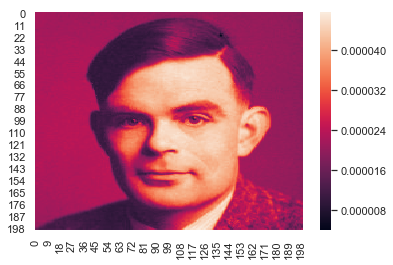

In [2]:
p_x = np.load('distribution.npy')
sns.heatmap(p_x)

In [4]:
def loss_bce(x, x_hat):
    BCE = F.binary_cross_entropy(
        x_hat.view(-1, 1), x.view(-1, 1), reduction='sum')
    return BCE


def gen_made_mask(height, width):
    return torch.tril(torch.ones((height, width)), diagonal=-1)


def train_validate(model, data, input_shape, optim, loss_fn, train):
    batch_size = 5 * 1024
    model.train() if train else model.eval()
    
    if train:
        perm = torch.randperm(data.size(0))
        idx = perm[:batch_size]
        x = data[idx]
    else:
        x  = data
        batch_size = data.size(0)

    x1 = one_hot(x[:, 0].unsqueeze(1), input_shape)
    x2 = one_hot(x[:, 1].unsqueeze(1), input_shape)

    x = torch.cat((x1, x2), dim=1).unsqueeze(1)

    x_hat = model(x)
    loss = loss_fn(x, x_hat)

    if train:
        optim.zero_grad()
        loss.backward()
        optim.step()

    return loss.item() / 2.0


def init_weights(module):
    for m in module.modules():
        if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
            init.xavier_normal_(m.weight.data)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias, 0.0)
        elif isinstance(m, nn.Sequential):
            for sub_mod in m:
                init_weights(sub_mod)

                
def one_hot(labels, n_class):
    # Ensure labels are [N x 1]
    if len(list(labels.size())) == 1:
        labels = labels.unsqueeze(1)
    mask = torch.FloatTensor(labels.size(0), n_class).fill_(0)
    # scatter dimension, position indices, fill_value
    return mask.scatter_(1, labels, 1)

In [80]:
class MaskedLinear(nn.Linear):
    def __init__(self, input_size, output_size, bias=True):
        super(MaskedLinear, self).__init__(input_size, output_size, bias=bias)
        self.register_buffer('mask', torch.ones([output_size, input_size]).double())
        self.input_size = input_size
        self.output_size = output_size
        self.init_parameters()
        
    def forward(self, x):
        return F.linear(x, self.mask * self.weight, self.bias)
    
    # FIX ME
    def set_mask(self, mask):
        self.mask = gen_made_mask(self.output_size, self.input_size)
        
    def reset_parameters(self):
        init.kaiming_uniform_(self.weight)
        if self.bias is not None:
            init.zeros_(self.bias)
            

# FIX ME
class MADE(nn.Module):
    def __init__(self, d=2, n_classes=200, hidden_size=200, n_hidden_layers=1):
        super(made_model, self).__init__()
        self.d = 2
        self.n_classes = n_classes
        self.input_size = self.d * self.n_classes
        
        self.hidden_size = hidden_size
        self.n_hidden_layers = n_hidden_layers
        
        self.layers = nn.ModuleList()
        self.layers.append(MaskedLinear(self.input_size, self.hidden_size))
        for i in range(n_hidden_layers - 1):
            self.layers.append(MaskedLinear(self.hidden_size, self.hidden_size))
        
        self.layers.append(MaskedLinear(self.hidden_size, self.input_size))
        
        
        
    def forward(self, x):
        x = F.linear(x, self.W * self.mask, self.b)
        x = self.sm(x)
        return x
    
        
    

40

In [81]:
# Sample 100.000 points from this distribution, split 80/20 test train
samples = np.random.choice(np.prod(p_x.shape), p=p_x.ravel(), size=100000)
samples_x = samples % 200
samples_y = samples // 200
samples = np.stack([samples_x, samples_y], axis=1)
train, valid = train_test_split(samples, test_size=0.2)

input_shape = (200, )
model = made_model(input_shape)
optim = Adam(model.parameters(), lr=0.001)
loss_fn = loss_bce
n_epochs = 5000


train = torch.from_numpy(train).type(torch.LongTensor)
valid = torch.from_numpy(valid).type(torch.LongTensor)
train_loss = []
val_loss = []
for epoch in range(0, n_epochs):    
    t_loss = train_validate(model, train, np.prod(input_shape), optim, loss_fn, train=True)
    train_loss.append(t_loss)
    
    if epoch % 100 == 0:
        v_loss = train_validate(model, valid, np.prod(input_shape), optim, loss_fn, train=False)
        val_loss.append(v_loss)

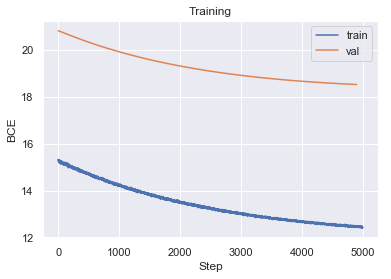

In [82]:
sns.set()
plt.plot(np.arange(len(train_loss)), train_loss, label='train')
plt.plot(np.arange(0, len(val_loss) * 100, 100), val_loss, label='val')
plt.title('Training')
plt.xlabel('Step')
plt.ylabel('BCE')
plt.legend()
plt.grid(True)

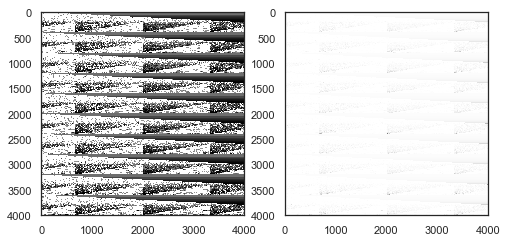

In [93]:
import cv2

grid = np.asarray([(x, y) for x in range(200) for y in range(200)])
grid = torch.from_numpy(grid).type(torch.LongTensor)

x1 = one_hot(grid[:, 0].unsqueeze(1), 200)
x2 = one_hot(grid[:, 1].unsqueeze(1), 200)

x = torch.cat((x1, x2), dim=1).unsqueeze(1)
    
draw = model(x)

draw = draw.detach().numpy()

draw = draw.reshape((4000, 4000)).T
draw *= -1
im = 255*(draw - np.min(draw)) / (np.max(draw) - np.min(draw))

plt.rcParams['figure.figsize'] = 8, 8
with sns.axes_style('white'):
    fig, axis = plt.subplots(nrows=1, ncols=2)
    
    axis[0].imshow(cv2.equalizeHist(im.astype(np.uint8)), cmap='gray')
    axis[0].set_title('')
    
    axis[1].imshow(im, cmap='gray')
    axis[1].set_title('')

plt.grid(False)